### Sample-Size Planning for Two-Sample Proportions Test

Suppose we flip two coins $n$ times each and observe $X_1^{\text{obs}}$ and $X_2^{\text{obs}}$ heads, respectively. We want to test the null hypothesis that the coins have the same probability $p_1$ of heads

$$H_0 : X_1\sim \text{Binomial}(n, p_1), X_2\sim \text{Binomial}(n, p_1),$$ 

versus the alternative hypothesis that the second coin has a probability $p_2$ of heads

$$H_1 : X_1\sim \text{Binomial}(n, p_1), X_2\sim \text{Binomial}(n, p_2).$$

As discussed in lecture, we want two guarantees:

1. When $H_0$ is true, the chance of a false discovery is at most $\alpha$ (the significance level).
2. When $H_1$ is true, the chance of a true discovery is at least $1 - \beta$ (the power).

A two-sample comparison of proportions hypothesis test will give us the first guarantee. To ensure the second, we compute a minimum sample size. Common Python libraries do not seem to have a function for this purpose. The following code does the trick.

In [1]:
import collections
import math
import scipy.optimize
import scipy.stats

PowerResult = collections.namedtuple(
    'PowerResult',
    ['n_per_group', 'p1', 'p2', 'significance_level', 'power'],
)

def power_prop_test(n_per_group=None, p1=None, p2=None, significance_level=0.05, power=None, 
                    two_sided=True):
    num_specified_arguments = (
        (n_per_group is None) + (p1 is None) + (p2 is None) + (significance_level is None) + 
        (power is None)  
    ) 
    if num_specified_arguments != 1:
        raise ValueError(
            "exactly one of 'n_per_group', 'p1', 'p2', 'significance_level' and 'power' "
            "must be None"
        )
    if significance_level is not None and not 0 < significance_level < 1:
        raise ValueError("'significance_level' must be in (0, 1)")
    
    def get_n_per_group(p1, p2, significance_level, power):
        if two_sided:
            significance_level /= 2
            
        pooled_sd_of_difference = math.sqrt((p1 + p2) * (1 - (p1 + p2)/2))
        unpooled_sd_of_difference = math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))
        
        significance_quantile = scipy.stats.norm.isf(significance_level)
        power_quantile = scipy.stats.norm.isf(1-power)
        
        return (
            (significance_quantile * pooled_sd_of_difference + power_quantile * unpooled_sd_of_difference) 
            / (p1 - p2)
        )**2

    if power is None:
        power = scipy.optimize.brentq(
            lambda power: get_n_per_group(p1, p2, significance_level, power) - n_per_group,
            significance_level / (1 + two_sided), 1 - 1e-10,
        )
    elif n_per_group is None:
        n_per_group = get_n_per_group(p1, p2, significance_level, power)
    elif p1 is None:
        p1 = scipy.optimize.brentq(
            lambda p1: get_n_per_group(p1, p2, significance_level, power) - n_per_group,
            0, p2 - 1e-10,
        )
    elif p2 is None:
        p2 = scipy.optimize.brentq(
            lambda p2: get_n_per_group(p1, p2, significance_level, power) - n_per_group,
            p1 + 1e-10, 1,
        )
    elif significance_level is None:
        significance_level = scipy.optimize.brentq(
            lambda significance_level: get_n_per_group(p1, p2, significance_level, power) - n_per_group,
            1e-10, 1 - 1e-10,
        )

    return PowerResult(n_per_group=n_per_group, p1=p1, p2=p2, significance_level=significance_level,
                       power=power)

For example, to ensure the chance of false discovery is no more than 5% when $H_0$ is true, while the chance of a true discovery is at least 80% when $p_1 = 0.1$ and $p_2 = 0.12$, we compute:

In [2]:
power_prop_test(p1=0.1, p2=0.12, power=0.8)

PowerResult(n_per_group=3840.847482436278, p1=0.1, p2=0.12, significance_level=0.05, power=0.8)

We need 3,841 subjects per group, or 7,682 subjects total. If we increase the power or decrease the minimum planned-for effect size, the sample size grows, sometimes dramatically:

In [9]:
math.ceil(power_prop_test(p1=0.1, p2=0.12, power=0.9).n_per_group)

5142

In [10]:
math.ceil(power_prop_test(p1=0.1, p2=0.11, power=0.8).n_per_group)

14751

In [11]:
math.ceil(power_prop_test(p1=0.1, p2=0.105, power=0.8).n_per_group)

57763

### Sequential Experiments

We wish to test whether a coin is fair or biased towards head (a one-sided test). We flip it 1,000 times and count the number of heads. We consider two schemes:

1. We flip 1,000 times, compute a p-value and decide whether to delcare a discovery or not.
2. We flip 100 times, compute a p-value and decide to declare a discovery. If not, we flip another 100 times, compute a new p-value based on all 200 flips, and so on, up to 1,000 total flips.

The following code simulates coin flipping. Our test statistic is the number of heads minus the number of tails, which is equal to twice the number of heads minus the number of flips.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

SEED = 1849332984

def make_paths(max_n, num_groups, num_paths, p=0.5):
    np.random.seed(SEED)
    group_size = max_n // num_groups
    increments = np.random.binomial(group_size, p, size=(num_groups, num_paths))
    paths = np.cumsum(2 * increments - group_size, axis=0)
    return(paths)

def get_test_stats(paths, max_n, maximal, normalize=None):
    if normalize is None:
        normalize = maximal
    num_groups = paths.shape[0]
    group_size = max_n // num_groups
    if normalize:
        sample_sizes = np.arange(1, num_groups + 1) * group_size
        paths = paths / np.sqrt(sample_sizes[:, None])
    
    if maximal:
        test_stats = np.max(paths, axis=0)
    else:
        test_stats = paths[-1, :]
        
    return(test_stats)

def plot_simulation_p_value(max_n=1000, num_groups=10, num_paths=100000,
                            t_observed=70, n_observed=None, maximal=False):
    if n_observed is None:
        n_observed = max_n
        
    paths = make_paths(max_n, num_groups, num_paths)
    test_stats = get_test_stats(paths, max_n, maximal)
    
    if maximal:        
        t_observed /= np.sqrt(n_observed)
        x_label = "$T_{%d}^*$" % max_n 
        t_obs_label = "$t^*_{%d}$" % max_n
    else:
        x_label = "$T_{%d}$" % max_n
        t_obs_label = "$t^{obs}_{%d}$" % max_n
        
    print('p-value: {:.3f}'.format(np.mean(test_stats >= t_observed)))
    
    FONT_SIZE = 15
    plt.style.use('default',)
    rc('text', usetex=True)
    plt.figure(figsize=(10,3))
    plt.hist(test_stats, bins=30, color='dimgray')
    plt.axvline(x=t_observed, c='k', ls='--')
    plt.xlabel(x_label, size=FONT_SIZE)
    plt.text(t_observed * 1.05, 30 * np.sqrt(num_paths), t_obs_label, size=FONT_SIZE)
    plt.tick_params(
       axis='y', which='both', left=False,      
       right=False, labelleft=False
    ) 
    plt.show()

p-value: 0.014


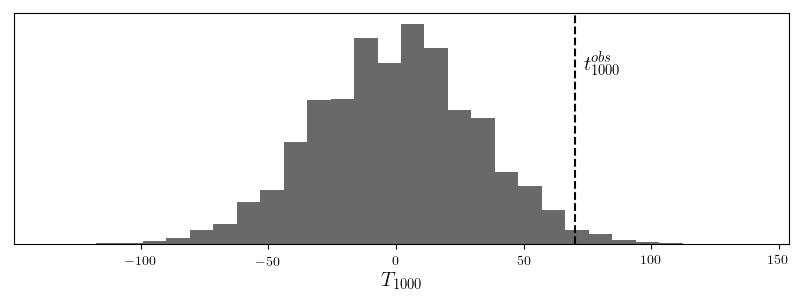

In [43]:
plot_simulation_p_value()

The above shows the fixed-sample case, with 70 more heads than tails after 1,000 flips. For the sequential case, we normalize each test statistic, dividing (# heads - # tails) by the square root of the sample size (more on this below). We then compute the maximum normalized test statistic in each simulation run.

p-value: 0.054


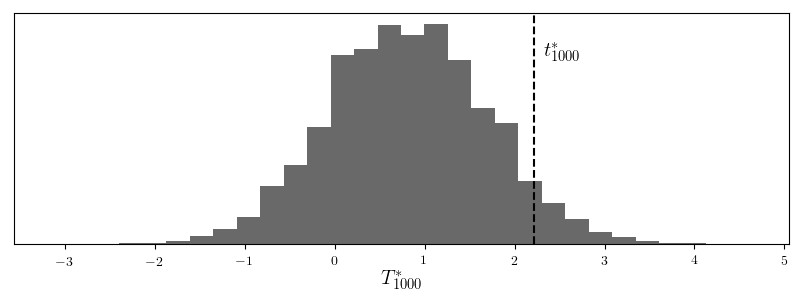

In [44]:
plot_simulation_p_value(maximal=True)

Because we're taking the maximum of ten test statistics, the histogram is no longer centered at zero, but rather shifted upwards. The p-value is larger, accounting for the fact that we may have "looked" ten times instead of just once. By computing the maximal test statistic over all ten looks in the reference distribtion, we guarantee that no matter which of the ten looks we're at, we can't exaggerate our findings beyond what's already represented in the simulated reference distribution. We'll simulate the process of sequential testing later. First, let's examine the paths of these test statistics to gain some intuition.

In [45]:
import pandas as pd

def plot_group_random_walk(max_n=1000, group_size=100, num_paths=200, normalize=False):
    num_groups = max_n // group_size
    
    paths = make_paths(max_n, num_groups, num_paths)
    
    group_sample_sizes = np.arange(num_groups + 1) * group_size
    
    plot_data = pd.DataFrame(np.concatenate((np.zeros((1, num_paths)), paths)))
    plot_data['n'] = group_sample_sizes
    plot_data = plot_data.melt('n', var_name='pathidx', value_name='position')

    y_max = 100

    if normalize:
        plot_data['position'] /= np.sqrt(np.maximum(1, plot_data['n']))
        y_max = 4
    
    FONT_SIZE = 15
    plt.style.use('seaborn-white',)
    
    for n in group_sample_sizes:
        plt.axvline(x=n, c='gray')
    
    for _, grp in plot_data.groupby(['pathidx']):
        plt.plot(grp['n'], grp['position'], c='k', alpha=.1) 
    
    plt.xticks(group_sample_sizes)
    plt.xlabel('Number of Flips, $n$', size=FONT_SIZE)
    plt.ylabel('$T_n/\\sqrt{n}$' if normalize else '$T_n$', size=FONT_SIZE)
    plt.show()

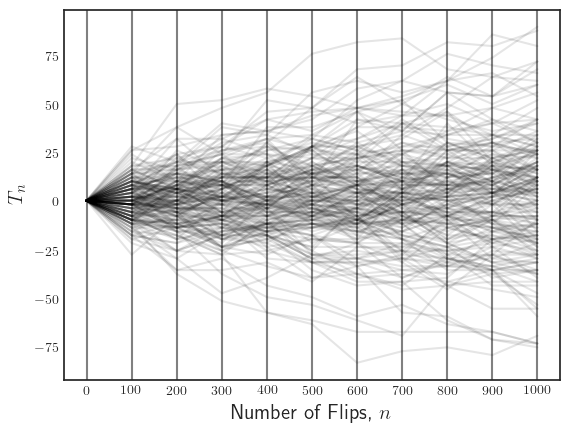

In [46]:
plot_group_random_walk()

Here we have not normalized the test statistics, so they grow in scale, at a rate of $\sqrt{n}$. By normalizing, we put them all on the same scale:

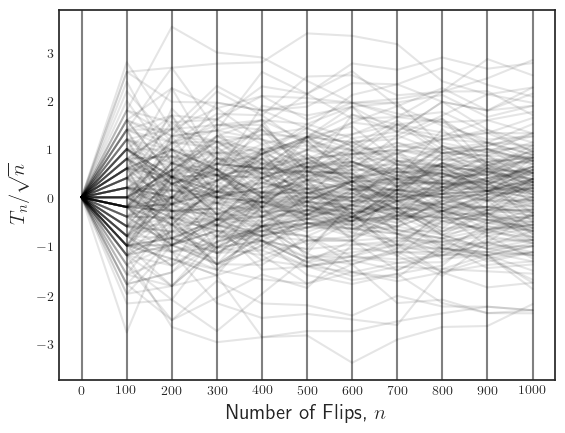

In [47]:
plot_group_random_walk(normalize=True)

To get a better feel for the effect of this normalization in practice, we'll simulate the actual process of sequential testing. First, we compute a reference distribution using the maximum of ten normalized test statistics, just as above. Then, we simulate flipping a (possibly biased) coin. We compute a p-value after 100 flips, 200 flips, etc. by comparing to our reference distribution. We stop and declare a discovery as soon as the p-value drops below 0.05, recording the time at which we stopped. (If we get to 1,000 flips and the p-value is still above 0.05, we fail to declare a discovery.)

In [57]:
# With ten groups, the stop times will be between 1-11, where 11 means we failed to declare
# a discovery.
def compute_stop_times(p, max_n, num_groups, num_paths, normalize):
    group_size = max_n // num_groups

    fair_paths = make_paths(max_n, num_groups, num_paths)
    reference_dist = get_test_stats(fair_paths, max_n, maximal=True, normalize=normalize)
    
    @np.vectorize
    def get_p_value(x):
        return(np.mean(reference_dist >= x))

    biased_paths = make_paths(max_n, num_groups, num_paths, p=p)

    if normalize:
        sample_sizes = np.arange(1, num_groups + 1) * group_size
        test_stats = biased_paths / np.sqrt(sample_sizes[:, None])
    else:
        test_stats = biased_paths
        
    maximal_test_stats = np.maximum.accumulate(test_stats, axis=0)
    p_vals = get_p_value(maximal_test_stats)
    p_vals = np.concatenate((p_vals, np.zeros((1, num_paths))))
    stop_times = np.argmax(p_vals < 0.05, axis = 0)
    
    return stop_times + 1

def plot_stop_times(p, max_n=1000, num_groups=10, num_paths=10000, normalize=True):
    group_size = max_n // num_groups
    stop_times = compute_stop_times(p, max_n, num_groups, num_paths, normalize)
    print('Power: ', np.mean(stop_times < 11))
    print('Mean stopping time: {:,} samples'.format(int(round(group_size * np.mean(np.minimum(10, stop_times))))))
    plt.hist(stop_times  * group_size, bins=(np.arange(num_groups+1) + 0.5) * group_size, 
             edgecolor='k', color='dimgray')
    plt.xticks((np.arange(num_groups) + 1) * group_size)
    plt.title('Distribution of time when we first reject $H_0$', size=15)
    plt.xlabel('Number of samples $n$', size=15)
    plt.tick_params(
       axis='y', which='both', left=False, right=False, labelleft=False
    ) 
    plt.show()

First, let's simulate flipping a fair coin.

Power:  0.0493
Mean stopping time: 970 samples


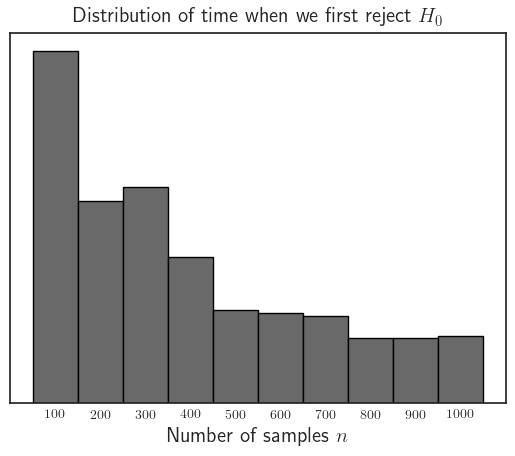

In [58]:
plot_stop_times(0.5)

We declare a false discovery in just about 5% of replications, verifying the guarantee of the sequential testing procedure. Now let's see what happens when the coin is biased, coming up heads 55% of the time.

Power:  0.865
Mean stopping time: 533 samples


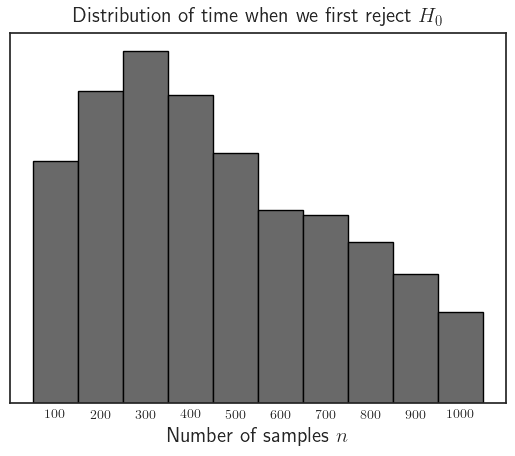

In [59]:
plot_stop_times(0.55)

We have achieved about 87% power while on average needing only a bit over 500 flips, half as many as the fixed-sample test with 1,000 flips. On the other hand, the fixed-sample test achieves higher power:

In [63]:
import statsmodels.stats.power
statsmodels.stats.power.tt_solve_power(
    # standardized effect size is difference in means, 0.55 - 0.5, divided by the standard
    # deviation of a Bernuolli(0.55) random variable.
    effect_size=0.05 / math.sqrt(0.55 * 0.45), 
    nobs=1000, 
    alpha=0.05, 
    alternative='larger',
)

0.9371402529287481

So the fixed-sample test has about 94% power. In the sequential test, we've sacrificed some power for the benefit of possibly using fewer samples. But we have some control over this, based on the way we normalize. Normalizing by $\sqrt{n}$, as we have done above, strikes a certain balance between power and expected sample size. But we could, for example, not normalize at all, instead just taking the maximum (# heads - # tails) over all ten interim analysis points. This makes it less likely that we'll stop early on, but gives more power overall:

Power:  0.9227
Mean stopping time: 652 samples


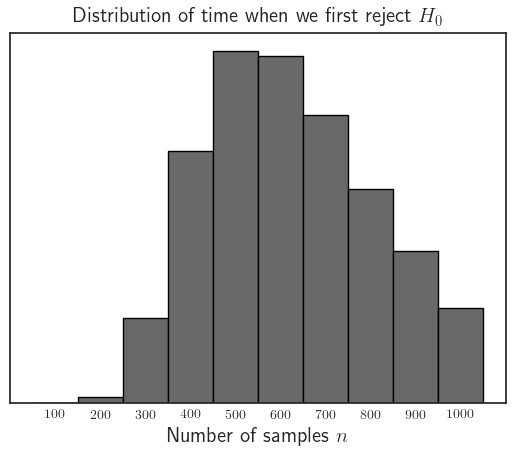

In [64]:
plot_stop_times(0.55, normalize=False)

Now we've sacrified very little power compared to the fixed-sample test, and still gained quite a bit in terms of expected sample size.